## 1. Постановка задачи


**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными. 

In [271]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [ ]:
data = pd.read_csv(
    "customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
data = data.copy()
print('Data shape: {}'.format(data.shape))
data.head(5)

Проведём анализ структуры таблицы.


### Задание 2.1
Сколько столбцов в данных кодируются числовыми типами (int/float)?

In [ ]:
df_numerics_only = data.select_dtypes(include=np.number)

# список имен числовых столбцов
colnames_numerics_only = data.select_dtypes(include=np.number).columns.tolist()

#  количество числовых столбцов
print(len(colnames_numerics_only))

### Задание 2.2
Выберите столбцы, в которых есть хотя бы один пропуск

In [ ]:
data.isnull().sum()

### Задание 2.3
Укажите, за какой промежуток времени представлены данные:



In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print(f'{data['InvoiceDate'].dt.date.min()} - {data['InvoiceDate'].dt.date.max()}')

### Задание 2.4

1) Каково максимальное количество товаров в заказе?

2) Каково минимальное количество товаров в заказе? 

3) Сколько, согласно данным, стоит самый дешёвый товар (за исключением товаров с отрицательной стоимостью)?

In [ ]:
display(data.describe())
data['UnitPrice'].sort_values()

### Задание 2.5
1) Сколько уникальных клиентов покупали товары за период выгрузки датасета?

2) Сколько уникальных стран содержится в столбце Country (исключая специальный код 'Unspecified', обозначающий неопределенную страну)?

3) Идентификатор самого популярного товара (StockCode):


In [ ]:
print(data['CustomerID'].nunique(), 'уникальных клиентов')
print(data[data['Country'] != 'Unspecified']['Country'].nunique(), 'уникальных стран')
print(data['StockCode'].value_counts().index[0], 'идентификатор самого популярного товара')

## 3. Предобработка и очистка данных

### Задание 3.1

1) Сколько всего в таблице пропущенных значений?

2) Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях.  
Удалим строки, содержащие пропуски в этих столбцах.



In [ ]:
print(data.isnull().sum().sum(), 'всего пропусков')
data = data.dropna(subset=['CustomerID', 'StockCode'], axis =0)
data.shape

### Задание 3.2
Следом за пропусками проверим наличие дубликатов.

1) Сколько в таблице полностью дублирующихся записей?

2) Удалите дубликаты из таблицы. Сколько строк осталось?



In [ ]:
print(data.duplicated().sum())
data = data.drop_duplicates()
data.shape

### Задание 3.3
Проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом. 

Сколько транзакций из таблицы negative_quantity не содержат в номере заказа признак возврата?

In [ ]:
returns = data[(data['Quantity'] < 0) & ~(data['InvoiceNo'].str.startswith('C'))]
returns.shape

Определим, сколько уникальных товаров указано в транзакции для каждой уникальной пары «клиент-заказ»:


In [ ]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

### Задание 3.4
Добавьте во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

Сколько процентов заказов в таблице являются возвратами? Ответ приведите в виде целого числа.


In [ ]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if (x.startswith('C')) else 0)
nb_products_per_basket['order_canceled'].value_counts(normalize=True) * 100

Давайте поближе взглянем на отмененные заказы:


In [ ]:
data[data['CustomerID'] == '12346']

Можно заметить пару заказ-отмена

### Задание 3.5
Проверим, что для каждой отменённой транзакции в базе данных существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

In [ ]:
negative_quantity = data[(data['Quantity']<0)]
returns = negative_quantity.copy()
returns.reset_index(inplace=True)
# Меняем количество на положительное 
returns['Quantity'] = -returns['Quantity'] 
# Соединяем оригинальный сет и возвраты
matched = pd.merge(returns, data,
                    on=['StockCode', 'CustomerID', 'Quantity'], how='inner')
matched.drop_duplicates(subset='index', inplace=True)
print(f'Количество несовпадений: {negative_quantity.shape[0] - matched.shape[0]}')


### Задание 3.6
Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.



In [ ]:
negative_quantity_d = negative_quantity[(negative_quantity['StockCode'] != 'D')]
returns_d = negative_quantity_d.copy()
returns_d.reset_index(inplace=True)
# Меняем количество на положительное 
returns_d['Quantity'] = -returns_d['Quantity'] 
# Соединяем оригинальный сет и возвраты
matched = pd.merge(returns_d, data,
                    on=['StockCode', 'CustomerID', 'Quantity'], how='inner')
matched.drop_duplicates(subset='index', inplace=True)
print(f'Количество несовпадений: {negative_quantity_d.shape[0] - matched.shape[0]}')

In [ ]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

* Проблема в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. 

* Также клиент может отменить не весь заказ, а только его часть.

Создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции.  


In [ ]:
# Функция get_quantity_canceled() принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, 
# в котором указано количество возвращённого впоследствии товара для каждой транзакции.
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for col in negative_quantity.itertuples():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col.CustomerID) &
                        (data['StockCode']  == col.StockCode) & 
                        (data['InvoiceDate'] < col.InvoiceDate) & 
                        ((quantity_canceled.loc[col.Index] - col.Quantity) <= data['Quantity'])].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет одного и более контрагентов
        # Добавляем количество отмененного в столбец QuantityCanceled 
        else:
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = quantity_canceled.loc[index_order] - col.Quantity       
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)

### Задание 3.7
Подсчитайте суммарное количество отмененных товаров в столбце QuantityCanceled. 


In [ ]:
data['QuantityCanceled'] = quantity_canceled
data['QuantityCanceled'].sum()

## Задание 3.8
Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалите из таблицы транзакции, в поле которых указано отрицательное количество товара.  
Сколько записей осталось?

In [ ]:
data = data[data['Quantity'] > 0]
data.shape

### Задание 3.9
Найдем коды товаров, которые начинаются с латинских букв. 

1) Сколько уникальных специальных видов транзакций вам удалось найти?

Специальные операции не характеризуют клиентов, поэтому такие записи не нужны. Удалиv все специальные транзакции из таблицы. 

2) Сколько записей осталось?



In [ ]:
product_codes = data[data['StockCode'].str.contains('^[a-zA-Z]\d*', regex=True)]
print(product_codes['StockCode'].value_counts())
data['StockCode'].value_counts()

In [ ]:
data = data[data['StockCode'].str.match('^\d')]
data.shape

### Задание 3.10
На некоторые товары установлена цена в 0 фунтов стерлингов. 

1) В скольких транзакциях цена за единицу товара равна 0?

2) Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться.  
Сколько записей осталось?



In [ ]:
print(data[data['UnitPrice'] == 0].shape)
data = data[data['UnitPrice'] != 0]
data.shape

In [ ]:
data.to_csv('data_eda.csv')

## 4. Разведывательный анализ данных

In [ ]:
data = pd.read_csv('data_eda.csv')

### Задание 4.1
Выясним, в каких странах живут клиенты.


In [ ]:
country_df = data[['Country', 'CustomerID']]
# Оставим только уникальных клиентов
country_df = country_df.drop_duplicates()
country_df = country_df.groupby('Country').count()
country_df = country_df.sort_values('CustomerID', ascending=False)
display(country_df.head())

fig = px.choropleth(country_df, locations=country_df.index, locationmode = 'country names', color='CustomerID', scope='world', color_continuous_scale = 'spectral')
fig.show()

### Задание 4.2
Топ-3 стран по количеству поступающих заказов.




In [ ]:
country_df = data[['Country', 'InvoiceNo']]

country_df = country_df.groupby('Country').count()
country_df = country_df.sort_values('InvoiceNo', ascending=False)
display(country_df.head())
fig = px.bar(country_df.head())
fig.show()

### Задание 4.3
Давайте добавим в датасет общую цену заказа, назовём её TotalPrice.

 **TotalPrice = UnitPrice * (количество товаров в заказе - количество возвращённых товаров).**


In [ ]:
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])
print(f'Средняя стоимость заказов = {round(data['TotalPrice'].mean())}')

### Задание 4.4

Постройте визуализацию и выделите топ-3 стран, клиенты из которых приносят компании больше всего выручки:


In [ ]:
country_df = data[['Country', 'TotalPrice']]

country_df = country_df.groupby('Country').sum()
country_df = country_df.sort_values('TotalPrice', ascending=False)
display(country_df.head())
fig = px.bar(country_df.head())
fig.show()

### Задание 4.5
Добавим временные признаки месяца, дня недели и часа совершения покупки.  
Определим самые прибыльные месяца.

In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Date'] = data['InvoiceDate'].dt.date
data['Month'] = data['InvoiceDate'].dt.month
data['Day_of_week'] = data['InvoiceDate'].dt.weekday
data['Hour'] = data['InvoiceDate'].dt.hour

month_df = data[['Month', 'TotalPrice']]
month_df = month_df.groupby('Month').sum()
month_df = month_df.sort_values('TotalPrice', ascending=False)
display(month_df.head())
fig = px.bar(month_df, x = month_df.index, y = 'TotalPrice')
fig.show()

### Задание 4.6
Визуализируем количество заказов для каждого дня недели.


In [ ]:
day_df = data[['Day_of_week', 'TotalPrice']]
day_df = day_df.groupby('Day_of_week').sum()
display(day_df)
fig = px.bar(day_df)
fig.show()

### Задание 4.7
=
Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

Постройте визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

Выберите верные утверждения:
* Больше всего заказов совершается в дневное время в интервале от 18 до 20 часов
* Больше всего заказов совершается в вечернее время в интервале от 10 до 15 часов
* Начиная с 21 часа вечера и до 6 утра (не включительно) заказы не поступают 
* Заказы поступают во все периоды дня


In [ ]:
date_hour_df = data[['Date', 'Hour', 'Quantity']]
date_hour_df = date_hour_df.groupby(['Date', 'Hour']).mean().reset_index()
display(date_hour_df)
fig = px.bar(date_hour_df, x = 'Hour', y = 'Quantity')
fig.show()

## 5. RFM-сегментация клиентов: часть 1

Сформируем признаки, на основе которых будем производить сегментацию клиентов.

Воспользуемся методом RFM.

Нужно рассчитать RFM-характеристики для каждого из клиентов в датасете, и на их основе с помощью методов кластеризации построить подобные сегменты клиентов.

### Задание 5.1

Cгруппируем данные по идентификаторам клиента и рассчитаем следующие  агрегированные характеристики:

* Recency: для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency: рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary: Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

In [ ]:
rfm_table = data.groupby("CustomerID").agg({'InvoiceDate':'max', 'InvoiceNo':'nunique', 'TotalPrice':'sum'})
date = pd.Timestamp(2011, 12, 10)
rfm_table['InvoiceDate'] = (date - rfm_table['InvoiceDate']).dt.days
rfm_table.columns = ['Recency', 'Frequency', 'Monetary']

rfm_table

Построим коробчатые диаграммы для каждого из признаков:

In [ ]:
boxes = [px.box(rfm_table, x=column) 
        for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('boxplot_1.html')
fig.show()

- Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук),
- клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.


### Задание 5.2
Удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [ ]:
frequency_quantile = rfm_table['Frequency'].quantile(0.95)
monetary_quantile = rfm_table['Monetary'].quantile(0.95)

rfm_table_cleaned = rfm_table[(rfm_table['Frequency'] <= frequency_quantile) & (rfm_table['Monetary'] <= monetary_quantile)]

print(rfm_table_cleaned.shape[0])

In [ ]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('boxplot_2.html')
fig.show()

Построим визуализацию трёхмерного пространства признаков для оценки распределения:


In [ ]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


Видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег.


### Задание 5.3
Для стабильной работы метода главных компонент (PCA) данные необходимо стандартизировать/нормализовать. 

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                ('pca', PCA(n_components=2))])

rfm_table_processed = pipeline.fit_transform(rfm_table_cleaned)

pipeline['pca'].explained_variance_ratio_[0]

Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

In [ ]:
rfm_table_processed = pd.DataFrame(rfm_table_processed)
display(rfm_table_processed)
sns.scatterplot(data=rfm_table_processed, x=0, y=1);

Попробуем разделить это пространство главных компонент на сегменты. 

### Задание 5.4
Воспользуемся методом k-means. 

Переберём возможные значения кластеров от 2 до 10. 


In [ ]:
def get_silhouette_kmeans(cluster_num, X):
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', random_state=42)
    k_means.fit(X)
    silhouette = silhouette_score(X, k_means.predict(X))
    return silhouette

silhouette_res = {"silhouette": [], "cluster": []}

X = rfm_table_processed

for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette_kmeans(cluster_num, X))
    silhouette_res["cluster"].append(cluster_num)

silhouette_df_kmeans = pd.DataFrame(silhouette_res)
display(f'Максимальное значение коэффициента силуэта = {silhouette_df_kmeans['silhouette'].max():.2f}')

sns.set_style("darkgrid")
sns.lineplot(data=silhouette_df_kmeans, x="cluster", y="silhouette", marker= "o")

### Задание 5.5
Теперь возьмём EM-алгоритм.

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


In [ ]:
def get_silhouette_em(cluster_num, X):
    gm_clustering = GaussianMixture(n_components=cluster_num, random_state=42)
    gm_clustering.fit(X)
    silhouette = silhouette_score(X, gm_clustering.predict(X))
    return silhouette

silhouette_res_em = {"silhouette": [], "cluster": []}

X = rfm_table_processed

for cluster_num in range(2, 10):
    silhouette_res_em["silhouette"].append(get_silhouette_em(cluster_num, X))
    silhouette_res_em["cluster"].append(cluster_num)

silhouette_df_em = pd.DataFrame(silhouette_res_em)
display(f'Максимальное значение коэффициента силуэта = {max(silhouette_res_em['silhouette']):.2f}')

sns.set_style("darkgrid")
sns.lineplot(data=silhouette_res_em, x="cluster", y="silhouette", marker= "o")

### Задание 5.6
Посмотрим на распределение кластеров.

Обучим KMeans модель, так как коэффициент силуэта у неё выше.



In [ ]:
k_means =  KMeans(n_clusters=3, random_state=42)
k_means.fit(rfm_table_processed)

prediction = k_means.predict(rfm_table_processed)
rfm_table_processed['Label'] = prediction

In [ ]:
display(rfm_table_processed['Label'].value_counts())

sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue='Label');
rfm_table_processed

### Задание 5.7

Вернёмся от декомпозированных данных к RFM-таблице

In [ ]:
rfm_table_cleaned['Cluster'] = prediction
rfm_table_cleaned.groupby('Cluster').mean()

### Полярная диаграмма
Используем Radar Chart для визуализации признаков.

Реализуем функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы.

Все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум.

In [ ]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # список признаков
    features = grouped_data.columns
    
    fig = go.Figure()
    # визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))

    fig.update_layout(
        showlegend=True,
        autosize=False, 
        width=800, 
        height=800, 
    )
    
    fig.show()
    

### Задание 5.8

Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 


In [ ]:
rfm_table_cleaned = rfm_table_cleaned[['Recency',	'Frequency',	'Monetary']]
plot_cluster_profile(rfm_table_cleaned, 3)

Описание кластеров:
* Кластер 1 - соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 2 - соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты.
* Кластер 3 - соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.

### 6. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

### Задание 6.1
Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление.



In [ ]:
pipeline_tsne = Pipeline([('scaler', StandardScaler()), 
                ('tsne', TSNE(perplexity=50, random_state=100))])

rfm_table_tsne = pipeline_tsne.fit_transform(rfm_table_cleaned)

In [ ]:
rfm_table_tsne = pd.DataFrame(rfm_table_tsne)
rfm_table_tsne

Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


In [ ]:
fig = plt.figure(figsize=(5, 5))
sns.scatterplot(data=rfm_table_tsne, x=0, y=1); 

t-SNE алгоритм сгруппировал наиболее похожие объекты в подобие кластеров.


### Задание 6.2
Снова воспользуемся методом k-means после преобразований t-SNE алгоритма. 



In [ ]:
silhouette_res = {"silhouette": [], "cluster": []}

X = rfm_table_tsne

for cluster_num in range(2, 9):
    silhouette_res["silhouette"].append(get_silhouette_kmeans(cluster_num, X))
    silhouette_res["cluster"].append(cluster_num)

silhouette_df_kmeans = pd.DataFrame(silhouette_res)
display(f'Максимальное значение коэффициента силуэта = {silhouette_df_kmeans['silhouette'].max():.2f}')

sns.set_style("darkgrid")
sns.lineplot(data=silhouette_df_kmeans, x="cluster", y="silhouette", marker= "o")

### Задание 6.3
Также воспользуемся EM-алгоритом. 


In [ ]:
silhouette_res_em = {"silhouette": [], "cluster": []}

X = rfm_table_tsne

for cluster_num in range(2, 9):
    silhouette_res_em["silhouette"].append(get_silhouette_em(cluster_num, X))
    silhouette_res_em["cluster"].append(cluster_num)

silhouette_df_em = pd.DataFrame(silhouette_res_em)
display(f'Максимальное значение коэффициента силуэта = {max(silhouette_res_em['silhouette']):.2f}')

sns.set_style("darkgrid")
sns.lineplot(data=silhouette_res_em, x="cluster", y="silhouette", marker= "o")

### Задание 6.4
Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберите оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно. 

Все параметры, за исключением числа кластеров, оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



In [ ]:
def get_silhouette_ac(cluster_num, X):
    ac_clustering = AgglomerativeClustering(n_clusters=cluster_num)
    ac_clustering.fit(X)
    silhouette = silhouette_score(X, ac_clustering.labels_)
    return silhouette

silhouette_res_ac = {"silhouette": [], "cluster": []}

X = rfm_table_tsne

for cluster_num in range(2, 9):
    silhouette_res_ac["silhouette"].append(get_silhouette_ac(cluster_num, X))
    silhouette_res_ac["cluster"].append(cluster_num)

silhouette_df_em = pd.DataFrame(silhouette_res_ac)
display(f'Максимальное значение коэффициента силуэта = {max(silhouette_res_ac['silhouette']):.2f}')

sns.set_style("darkgrid")
sns.lineplot(data=silhouette_res_ac, x="cluster", y="silhouette", marker= "o")

### Задание 6.5
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture
* AgglomerativeClustering


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



Label
2    912
0    775
4    677
3    599
1    542
5    425
6    114
Name: count, dtype: int64

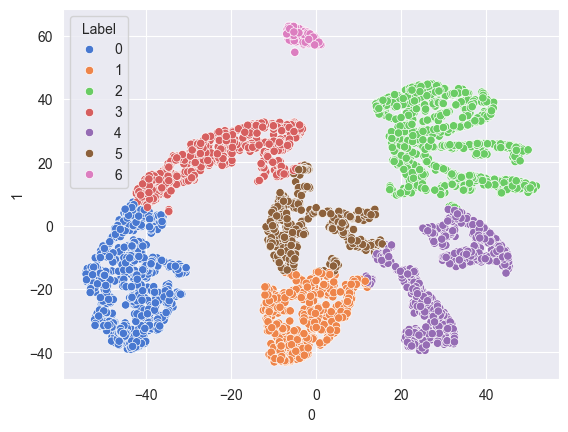

In [251]:
rfm_table_tsne = rfm_table_tsne[[0, 1]]

k_means =  KMeans(n_clusters=7, random_state=42)
k_means.fit(rfm_table_tsne)

prediction_tsne = k_means.predict(rfm_table_tsne)
rfm_table_tsne['Label'] = prediction_tsne


display(rfm_table_tsne['Label'].value_counts())

sns.scatterplot(data=rfm_table_tsne, x=0, y=1, hue='Label', palette='muted');


### Задание 6.6

Для составления профиля кластеров вернемся от декомпозированных данных к RFM-таблице.

In [260]:
rfm_table_cleaned['Cluster'] = prediction_tsne


### Задание 6.7
Визуализируйте профили семи кластеров в виде полярной диаграммы на основе средних RFM-характеристик.


In [255]:
rfm_table_cleaned = rfm_table_cleaned[['Recency',	'Frequency',	'Monetary']]
plot_cluster_profile(rfm_table_cleaned, 7)

* Кластер 1 - соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер 2 - соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер 3 - соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на большие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер 6 - соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер 5 - соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер 4 - соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер 0 - соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.


## 7. RFM-кластеризация клиентов: часть 3

Так как алгоритм t-SNE непараметрический, он не создаёт явной функции отображения. То есть нельзя применять алгоритм на новых данных. Вместо этого на основе данных с кластерами проведем классификацию.

### Задание 7.1

Разделим исходные данные на тренировочную и тестовую выборки в соотношении 80/20.

In [264]:
rfm_table_cleaned['Cluster'] = prediction_tsne
X = rfm_table_cleaned.drop(['Cluster'], axis=1)
y = rfm_table_cleaned['Cluster']


train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)
test_x


,Recency,Frequency,Monetary
CustomerID,,,
14312,46,6,1611.59
14673,3,5,1736.40
14243,8,10,2535.88
17084,35,2,2747.99
14851,23,2,511.35
...,...,...,...
13802,138,3,4179.42
12445,22,1,77.40
17410,16,5,1214.72


Алгоритм t-SNE является нелинейным методом понижения размерности. Можно предположить, что линейные модели, такие как логистическая регрессия, в данной задаче не помогут.
Поэтому сразу возьмём ансамблевые алгоритмы. 


### Задание 7.2
Начнём со случайного леса. С помощью GridSearchCV организуйте перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5.

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в случайном лесу?

2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [268]:
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}


clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf, 
                            param_grid=param_grid, 
                            cv=5, scoring='accuracy')

grid_search.fit(train_x, train_y)

optimal_max_depth = grid_search.best_params_['max_depth']
print(grid_search.best_params_)
print("Optimal max depth: ", optimal_max_depth)

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
Optimal max depth:  10


In [276]:
clf = RandomForestClassifier(criterion= 'gini', max_depth = 10, n_estimators = 100, random_state=42)
clf.fit(train_x, train_y)

pred_y = clf.predict(test_x)


accuracy = accuracy_score(test_y, pred_y)


print(f"Accuracy: {round(accuracy, 3)}")

Accuracy: 0.989


Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

### Задание 7.3
С помощью GridSearchCV организуйте перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5. 

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в градиентном бустинге?
Ответ: 6
2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [275]:
param_grid_gbc = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

gbc = GradientBoostingClassifier(random_state=42)

grid_search_gbc = GridSearchCV(estimator=gbc, 
                            param_grid=param_grid_gbc, 
                            cv=5, scoring='accuracy')

grid_search_gbc.fit(train_x, train_y)

optimal_max_depth = grid_search_gbc.best_params_['max_depth']
print(grid_search_gbc.best_params_)
print("Optimal max depth: ", optimal_max_depth)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Optimal max depth:  5


In [277]:
gbc = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 5, n_estimators= 200, random_state=42)
gbc.fit(train_x, train_y)

pred_y = gbc.predict(test_x)


accuracy = accuracy_score(test_y, pred_y)

print(f"Accuracy: {round(accuracy, 3)}")

Accuracy: 0.99


#### Проблемаой непараметричности t-SNE решена, и мы перешли от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.